In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np


In [2]:
df = pd.read_csv('train_commenttoxic.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [12]:
len(X)

159571

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
batch_x,batch_y = dataset.as_numpy_iterator().next()

In [15]:
batch_x

array([[  21,  636,  288, ...,    0,    0,    0],
       [  46, 1377,   31, ...,    0,    0,    0],
       [1815, 3477,  345, ...,    0,    0,    0],
       ...,
       [ 323,   73,  613, ...,    0,    0,    0],
       [  28, 2809,  171, ...,    0,    0,    0],
       [7951, 3177,  283, ...,    0,    0,    0]], dtype=int64)

In [16]:
batch_x.shape

(16, 1800)

In [17]:
len(dataset)

9974

In [18]:
len(dataset)*16#total data

159584

In [19]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh'))) #told by tensorflow to use tanh
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [25]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 11660s 2s/step - loss: 0.0609 - val_loss: 0.0436


<Figure size 800x500 with 0 Axes>

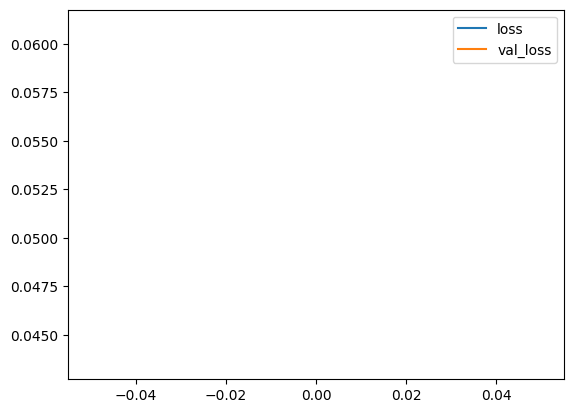

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [29]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [30]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 2s 2s/step


array([[0.9945695 , 0.13123363, 0.93507606, 0.01864576, 0.6901057 ,
        0.09324732]], dtype=float32)

In [31]:
batch=test.as_numpy_iterator().next()

In [32]:
test.as_numpy_iterator().next()

(array([[  905,    23,     2, ...,     0,     0,     0],
        [  435,  1782,   982, ...,     0,     0,     0],
        [  482,   200, 12972, ...,     0,     0,     0],
        ...,
        [    8,   617,     3, ...,     0,     0,     0],
        [    2,  1183, 12974, ...,     0,     0,     0],
        [   94,     8,    25, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0]], dtype=int64))

In [39]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [40]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 304ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 313ms/step


In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8405036926269531, Recall:0.6757592558860779, Accuracy:0.5295887589454651


In [ ]:
!pip install gradio

In [51]:
import tensorflow as tf
import gradio as gr

ModuleNotFoundError: No module named 'gradio'